# PubChem API in Python

By Avery Fernandez and Michael T. Moen

PubChem provides programmatic access to chemical data and bioactivity information from the National Center for Biotechnology Information (NCBI), enabling efficient retrieval and analysis of chemical structures, identifiers, properties, and associated biological activities.

Please see the following resources for more information on API usage:
- Documentation
    - <a href="https://pubchemdocs.ncbi.nlm.nih.gov/programmatic-access" target="_blank">PubChem Programmatic Access</a>
    - <a href="https://pubchem.ncbi.nlm.nih.gov/docs/pug-rest" target="_blank">PUG-REST API Documentation</a>
- Terms
    - <a href="https://www.ncbi.nlm.nih.gov/home/about/policies/" target="_blank">NCBI Policies and Disclaimers</a>
- Data Reuse
    - <a href="https://www.ncbi.nlm.nih.gov/home/about/policies/" target="_blank">NCBI Copyright Information</a>

_**NOTE:**_ The PubChem limits requests to a maximum of 5 requests per second.

*These recipe examples were tested on January 20, 2026.*

**Attribution:** This tutorial was adapted from supporting information in:

**Scalfani, V. F.**; Ralph, S. C. Alshaikh, A. A.; Bara, J. E. Programmatic Compilation of Chemical Data and Literature From PubChem Using Matlab. *Chemical Engineering Education*, **2020**, *54*, 230. https://doi.org/10.18260/2-1-370.660-115508 and https://github.com/vfscalfani/MATLAB-cheminformatics

## Setup

The following external libraries need to be installed into your environment to run the code examples in this tutorial:

- <a href="https://github.com/pandas-dev/pandas" target="_blank">pandas</a>
- <a href="https://github.com/psf/requests" target="_blank">requests</a>
- <a href="https://github.com/ipython/ipykernel" target="_blank">ipykernel</a>
- <a href="https://github.com/matplotlib/matplotlib" target="_blank">matplotlib</a>

We import the libraries used in this tutorial below:

In [1]:
import pandas as pd
import requests
from time import sleep
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. PubChem Similarity

### Get Compound Image

We can search for a compound and display an image. In this example, we look at 1-Butyl-3-methyl-imidazolium, which has a compound ID (CID) of 2734162.

In [2]:
BASE_URL = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/"
compoundID = "2734162"

response = requests.get(f"{BASE_URL}cid/{compoundID}/PNG")
img = response.content

# Save PNG to file
with open(f"{compoundID}.png", "wb") as out:
    out.write(img)

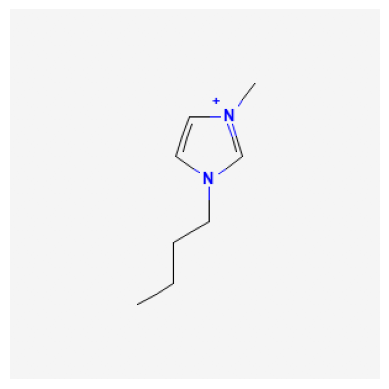

In [3]:
# Display compound PNG with matplotlib
img = mpimg.imread(f"{compoundID}.png")
plt.imshow(img)
plt.axis("off")
plt.show()

### Retrieve InChI and Isomeric SMILES

An International Chemical Identifier (InChI) is a textual representation of a substance's molecular structure.

In [4]:
properties = ["IsomericSMILES", "InChI"]
response = requests.get(
    f"{BASE_URL}cid/{compoundID}/property/{','.join(properties)}/JSON"
)
data = response.json()

# Display the response data
data

{'PropertyTable': {'Properties': [{'CID': 2734162,
    'SMILES': 'CCCCN1C=C[N+](=C1)C',
    'InChI': 'InChI=1S/C8H15N2/c1-3-4-5-10-7-6-9(2)8-10/h6-8H,3-5H2,1-2H3/q+1'}]}}

In [5]:
# Extract InChI
data["PropertyTable"]["Properties"][0]["InChI"]

'InChI=1S/C8H15N2/c1-3-4-5-10-7-6-9(2)8-10/h6-8H,3-5H2,1-2H3/q+1'

Isomeric SMILES is a textual representation of molecules that includes stereochemical and isotropic information.

In [6]:
# Extract Isomeric SMILES
data["PropertyTable"]["Properties"][0]["SMILES"]

'CCCCN1C=C[N+](=C1)C'

### Perform a Similarity Search

Search for chemical structures by similarity using a 2D Tanimoto threshold of 95% (defined by the `Threshold` parameter).

In [7]:
threshold = 95
response = requests.get(
    f"{BASE_URL}fastsimilarity_2d/cid/{compoundID}/cids/JSON?Threshold={threshold}"
)
data = response.json()
id_list = data["IdentifierList"]["CID"]

# Print the number of compounds that meet the similarity threshold
len(id_list)

367

In [8]:
# Display first 10 results
id_list[:10]

[61347,
 529334,
 2734161,
 118785,
 12971008,
 304622,
 2734162,
 11171745,
 11424151,
 11448496]

### Retrieve Identifier and Property Data

Get the following data for the retrieved compounds: `InChI`, `IsomericSMILES`, `MolecularWeight`, `HeavyAtomCount`, `RotableBondCount`, and `Charge`.

In [9]:
compound_data = []
properties = ["InChI", "IsomericSMILES", "MolecularWeight", 
              "HeavyAtomCount", "RotatableBondCount", "Charge"]

for cid in id_list[:25]:
    try:
        response = requests.get(
            f"{BASE_URL}cid/{cid}/property/{','.join(properties)}/JSON"
        )
        sleep(.25)
        response.raise_for_status()
        data = response.json()
        compound_data.append(data["PropertyTable"]["Properties"][0])
    except requests.exceptions.RequestException as e:
        print(f"Error fetching properties for CID {cid}: {e}")

# Convert results to a DataFrame
df = pd.DataFrame(compound_data)
df.head()

,CID,MolecularWeight,SMILES,InChI,Charge,RotatableBondCount,HeavyAtomCount
0,61347,124.18,CCCCN1C=CN=C1,"InChI=1S/C7H12N2/c1-2-3-5-9-6-4-8-7-9/h4,6-7H,...",0,3,9
1,529334,138.21,CCCCCN1C=CN=C1,"InChI=1S/C8H14N2/c1-2-3-4-6-10-7-5-9-8-10/h5,7...",0,4,10
2,2734161,174.67,CCCCN1C=C[N+](=C1)C.[Cl-],InChI=1S/C8H15N2.ClH/c1-3-4-5-10-7-6-9(2)8-10;...,0,3,11
3,118785,110.16,CCCN1C=CN=C1,"InChI=1S/C6H10N2/c1-2-4-8-5-3-7-6-8/h3,5-6H,2,...",0,2,8
4,12971008,252.10,CCCN1C=C[N+](=C1)C.[I-],InChI=1S/C7H13N2.HI/c1-3-4-9-6-5-8(2)7-9;/h5-7...,0,2,10


### Retrieve Images of Compounds from Similarity Search

61347


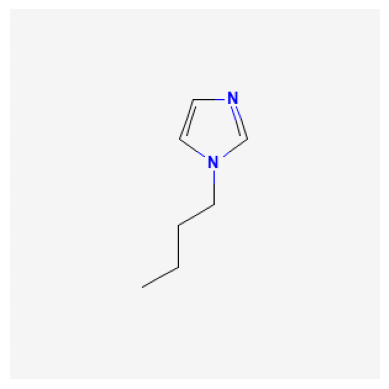

529334


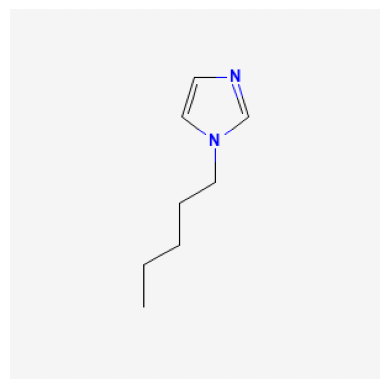

2734161


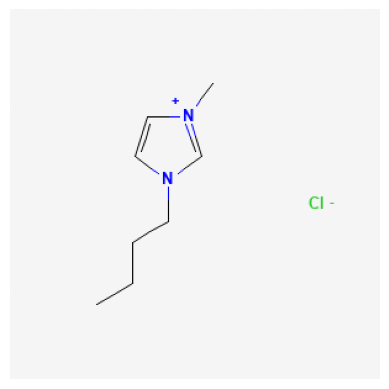

In [10]:
# Print the first 3 result images
for cid in id_list[:3]:
    try:
        response = requests.get(f"{BASE_URL}cid/{cid}/PNG")
        sleep(.25)
        response.raise_for_status()
        img = response.content
        with open(f"{cid}.png", "wb") as out:
            out.write(img)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching PNG for CID {cid}: {e}")
        continue

    print(cid)
    img = mpimg.imread(f"{cid}.png")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

## 2. PubChem SMARTS Search

We can search for chemical structures from a SMARTS substructure query using the `fastsubstructure` endpoint. Pattern syntax can be viewed at <a href="https://smarts.plus/" target="_blank">SMARTSPlus</a>.

In this example, we use vinyl imidazolium substructure searches.

In [11]:
smartsQ = [
    "[CR0H2][n+]1[cH1][cH1]n([CR0H1]=[CR0H2])[cH1]1",
    "[CR0H2][n+]1[cH1][cH1]n([CR0H2][CR0H1]=[CR0H2])[cH1]1",
    "[CR0H2][n+]1[cH1][cH1]n([CR0H2][CR0H2][CR0H1]=[CR0H2])[cH1]1"
]

### Perform a SMARTS query search

In [12]:
combinedList = []
for smarts in smartsQ:
    try:
        response = requests.get(f"{BASE_URL}fastsubstructure/smarts/{smarts}/cids/JSON")
        sleep(.25)
        response.raise_for_status()
        data = response.json()
        combinedList += data["IdentifierList"]["CID"]
    except requests.exceptions.RequestException as e:
        print(f"Error fetching substructure for SMARTS {smarts}: {e}")
        request = None

# Get number of CIDs found
len(combinedList)

1024

In [13]:
# Print first 10 CIDs
combinedList[:10]

[2881855,
 23724184,
 2881236,
 2881558,
 2881232,
 2881324,
 2881449,
 2881640,
 24766550,
 87560886]

### Retrieve Identifier and Property Data

In [14]:
smartsList = []
properties = ["InChI", "IsomericSMILES", "MolecularWeight", 
              "IUPACName", "HeavyAtomCount", "CovalentUnitCount", "Charge"]

# Demo for first 3 CIDs
for cid in combinedList[:3]: 
    try:
        response = requests.get(f"{BASE_URL}cid/{cid}/property/{','.join(properties)}/JSON")
        sleep(.25)
        response.raise_for_status()
        data = response.json()
        smartsList.append(data["PropertyTable"]["Properties"][0])
    except requests.exceptions.RequestException as e:
        print(f"Error fetching properties for CID {cid}: {e}")

# Convert results to a DataFrame
df = pd.DataFrame(smartsList)
df.head()

,CID,MolecularWeight,SMILES,InChI,IUPACName,Charge,HeavyAtomCount,CovalentUnitCount
0,2881855,353.21,COC1=C(C=C(C=C1)C(=O)C[N+]2=CN(C=C2)C=C)OC.[Br-],InChI=1S/C15H17N2O3.BrH/c1-4-16-7-8-17(11-16)1...,"1-(3,4-dimethoxyphenyl)-2-(3-ethenylimidazol-1...",0,21,2
1,23724184,378.08,C=CN1C=C[N+](=C1)CC(=O)C2=CC=C(S2)Br.[Br-],InChI=1S/C11H10BrN2OS.BrH/c1-2-13-5-6-14(8-13)...,1-(5-bromothiophen-2-yl)-2-(3-ethenylimidazol-...,0,17,2
2,2881236,362.0,C=CN1C=C[N+](=C1)CC(=O)C2=CC(=C(C=C2)Cl)Cl.[Br-],InChI=1S/C13H11Cl2N2O.BrH/c1-2-16-5-6-17(9-16)...,"1-(3,4-dichlorophenyl)-2-(3-ethenylimidazol-1-...",0,19,2


### Retrieve Images of CID Compounds from SMARTS Search

2881855


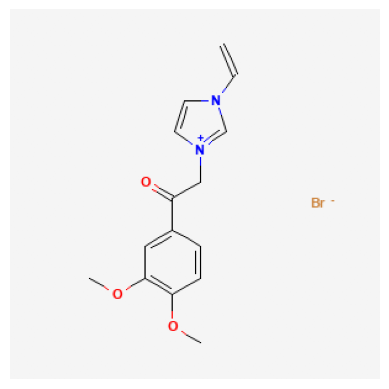

23724184


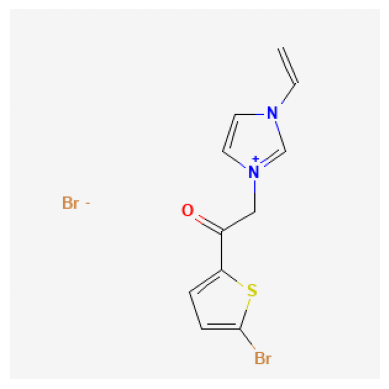

2881236


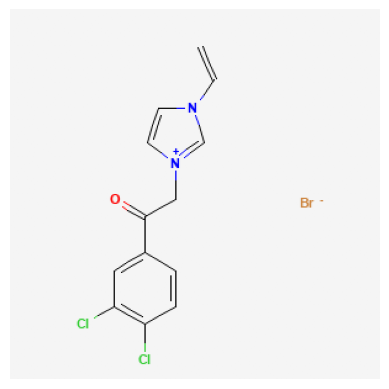

In [15]:
for cid in combinedList[:3]:
    try:
        response = requests.get(f"{BASE_URL}cid/{cid}/PNG")
        sleep(.25)
        response.raise_for_status()
        img = response.content
        with open(f"{cid}.png", "wb") as out:
            out.write(img)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching PNG for CID {cid}: {e}")
        continue

    # Display image
    print(cid)
    img = mpimg.imread(f"{cid}.png")
    plt.imshow(img)
    plt.axis("off")
    plt.show()